In [1]:
from sys import path
path.append('../')
import estimation as est
import LinearModels as lm
import SampleSelection_post as ssm

import numpy as np
import pandas as pd
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import optimize

%load_ext autoreload
%autoreload 2

# Introduction

In this dataset, you will use a part of the dataset from
Conley and Decarolis (2016). The data contains bids for public procurement
auctions for roadwork in Italy. In 2008, the Turin Court of Justice
ruled that in 276 auctions for roadwork held between 2000 and 2003, the
auctions had been rigged by 8 cartels made up of 95 firms. It turns out
that the auction format, called the Average Bid Auction (ABA), is
particularly susceptible to collusion between bidders. However, for a
cartel to be successful at one particular auction, it is essential that
many cartel participants be present at that auction. When enough of the
cartel is present at the auction, they are able to strategically
manipulate the average bid.

The implication is that the bids made by a given firm depends on the
identity of other firms showing up at the auction. This contradicts a
perfectly competitive setting, in which firms should not condition their
bids on the specific identities of their opponents. Thus, one can
test for (lack of) perfect competition by checking whether the bid posted by a firm
depends on how closely connected the firm is to other firms in that
auction (see Conley and Decarolis (2016) for details on how to quantify connectivity). 
If firms were randomly distributed across auctions, then there
should be no systematic link between these quantities.
In that case, we could just
regress the bid on how closely connected the firm is to other
firms in the auction, controlling for proxies for the "size" of the firm
(labor, capital, etc.).

The issue is that firms are *not* randomly allocated to auctions. Instead,
firms are more likely to participate in auctions involving sites that are close to their
headquarters. Moreover, the distance to the site of the roadwork project being
auctioned may act as our **exclusion restriction** under the following
assumptions:

1.  Firms prefer to win (hence, are more likely to bid on) projects close to home.

2.  Conditional on participating in an auction, distance does not matter for the
    *marginal* cost of conducting roadwork.

The figure below shows the distribution of
distances from all eligible firms to the sites, split by whether the
firm chose to participate or not. This clearly shows that distance
affects the likelihood of participation.

<img src="../smaller_pic.png" alt="Drawing" style="width: 500px;"/>

Part 2 may certainly be criticized. (Food for thought: Think about which types of projects
and firm behavior fit this description, and which types that do not.) Coming up
with credible exclusion restrictions is a delicate matter. Here we focus on
the mechanics of estimation with sample selection.


# Data

After deleting rows with missing observations, the data covers 891
auctions where a large number of firms considered whether or not to make
a bid. There are $N=91,845$ observations where a firm was eligible to
make a bid, and if it did, we observe the variable $y_{1i}=1$ (called
`participation` in the data). Otherwise, $y_{1i}=0$.

The submitted bid, which is only available for the 37,699 observations
where $y_{1i}=1$, is the variable `bid_discount`, which we denote
$y_{2i}$. It indicates the percentage discount relative to the
reservation price chosen by the auctioneer, which a firm is willing to
conduct the project for. The variable is missing (i.e. equal to `NaN`)
whenever $y_{1i}=0$ -- that is, when the given firm did not submit a bid
in the auction.

The exclusion restriction to be used is $z_{i}=$ `logmiles_fiwo`, which
is the log of (one plus) the miles between the address of the firm
(rather, the centroid of the zip code of the firm) and the site of the
project under procurement. The remaining variables are described below:

| **Variable** | **Description** |
| ---- | ---- |
| backlog_lagged  | a measure of the number of projects currently in progress at the firm. 	|
| logcapital | log of the total capital (accounting variable).	|
| labor | measure of employed labor.	|
| count_linktot_out  | A measure of closeness to other firms.	|
| auction_type | =0 if the auction is an Average Bid Auction,	|
|				|=1 for First Price Sealed Bid.	|
| participated  | whether the firm submitted a bid (yi1).	|
| logmiles_fiwo | distance from the firm to the location of the project under auction.	|
| firm_type_unlim_liab  | Firm is not limited liability.	|
| auction_id | ID variable for the auction.	|
| region | Dummy for the region in which the project is to take place. 	|
| year | Calendar year.	|

# The Heckman 2-step

Suppose our dataset consists of $N$ observations of
$\{x_{i},y_{2i}\}_{i=1}^{N}$, where $y_{2i}$ indicates
participation ("selection") and $x_{i}\in\mathbb{R}^{K}$. For auction
participants $\{i|y_{2i}=1\}$, we furthermore see the bid
$y_{1i}$, a real number. 

We adopt the Heckman model: 

$$
\begin{aligned}
y_{1i} & = \mathbf{x}_{1i}\boldsymbol{\beta}_o+u_{i},\\
y_{2i} & = \mathbf{1}\{\mathbf{x}_{i}\boldsymbol{\delta}_o+v_{i}>0\},\\
\left(u_i,v_i\right) & \text{ and } \mathbf{x}_i \text{ independent},\\
v_i&\sim\mathrm{N}\left(0,1\right),\\
\mathrm{E}[u_i \mid v_{i}=v] & = \gamma_{o} v.
\end{aligned}
$$

We prepare the data below.

In [2]:
# Since we are doing some more advanced data choices, we start by using pandas.
# This makes the whole process easier.
data = pd.read_csv('conley_decariolis.csv', sep=',')
data['t'] = data['year'] - min(data['year'])

In [3]:
# Create labels for variables
y2lbl = 'participated'
exclusion_restriction = 'logmiles_fiwo'
x2lbl = ['backlog_lagged',  'logcapital', 'count_linktot_in', 'labor', 'firm_type_unlim_liab', 't']
# ^-- all explanatory variables but the exclusion restriction

# We want to check for missings and remove them, but only for variables that we are interested in.
# We therefore gather all the labels into one "check_missing" label.
check_missing = x2lbl.copy()
check_missing.append(y2lbl)
check_missing.append(exclusion_restriction)

In [4]:
# Keep only auctions that are of type "average bid", which is the 0 category.
data = data[data['auction_type'] == 0.0]

# Remove missings only present in the variables denoted by check_missing labels.
data.dropna(inplace=True, subset=check_missing)

In [5]:
# Allocate data.
# y2 is whether a firm participated in the auction or not.
y2 = data[y2lbl].to_numpy().reshape(-1, 1)

# Exclusion restriction is distance from company to job.
z = data[exclusion_restriction].to_numpy().reshape(-1, 1)

x2 = data[x2lbl].to_numpy()
cnst = np.ones(y2.size).reshape(-1, 1)
x2 = np.hstack((x2, cnst))

# x (and y2) is to be used for the participation equation.
x = np.hstack((z, x2))

# y1 denotes the bid.
# We now keep in x1 only those who bid on the auction
y1 = data['bid_discount'][data['participated'] == 1].to_numpy().reshape(-1, 1)
x1 = x2[data['participated'] == 1]

# Add constant to labels
x2lbl.append('const')
# add exclusion restriction to labels
xlbl = x2lbl.copy()
xlbl.append(exclusion_restriction)

## Question 1:
Estimate the bid equation without controlling for selection into the sample. Gather the results in a table, and focus on the effect of `count_linktot_in` as a proxy for firm connectivity. Based on these preliminary results, does connectivity appear to matter?

In [6]:
ols_result = lm.estimate(y1, x1)
lm.print_table(
    ('Bid discount', x2lbl), 
    ols_result, 
    title="Results w/o accounting for selection.", 
    floatfmt='.4f'
)

Results w/o accounting for selection.
Dependent variable: Bid discount

                         Beta      Se    t-values
--------------------  -------  ------  ----------
backlog_lagged        -0.0484  0.1756     -0.2755
logcapital            -0.1399  0.0212     -6.6077
count_linktot_in       0.0132  0.0018      7.2640
labor                  0.0041  0.0009      4.7850
firm_type_unlim_liab  -1.0389  0.1173     -8.8547
t                      0.6685  0.0425     15.7440
const                 12.7181  0.0725    175.3357
R² = 0.010
σ² = 27.444


c:\Users\Andreas\AppData\Local\Programs\Python\Python310\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


## Question 2: 
Replicate the histogram above, showing that there might be a selection bias. You do this by using the `Data` frame, and plot the histograms of `logmiles_fiwo` both for `participated == 0` and `participated == 1`. See if you are able to plot both histograms in the same plot, with a transparent overlap.

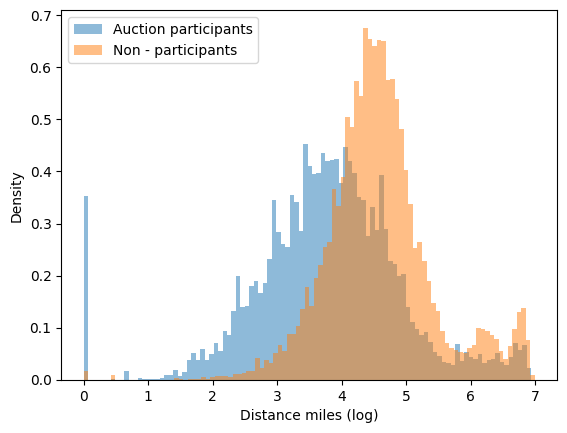

In [7]:
# Plot histograms
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['logmiles_fiwo'][data['participated'] == 1], bins=100, alpha=0.5, density=True)
ax.hist(data['logmiles_fiwo'][data['participated'] == 0], bins=100, alpha=0.5, density=True) 
ax.legend(['Auction participants', 'Non - participants'])
ax.set_xlabel('Distance miles (log)')
ax.set_ylabel('Density') ;

## Question 3
Conduct the "Heckit" procedure (Wooldridge's Procedure 19.1) using `logmiles_fiwo` as the exclusion restriction. 
Does `logmiles_fiwo` (still) seem relevant?
Is the coefficient on the inverse Mills ratio significant? How do you interpret this finding? 
Can you draw any conclusion on whether `count_linktot_in` seems to matter?

In [8]:
first_step = est.estimate(
    ssm.q, ssm.starting_values(y2, x), y2, x
)
est.print_table(xlbl, first_step, title='First step results')

Optimization terminated successfully.
         Current function value: 0.513605
         Iterations: 34
         Function evaluations: 342
         Gradient evaluations: 38
Optimizer succeded after 34 iter. (342 func. evals.). Final criterion:   0.5136.
First step results


,theta,se,t
backlog_lagged,-0.1243,0.0050,-24.7226
logcapital,0.0548,0.0436,1.2558
count_linktot_in,0.0520,0.0035,14.7092
labor,0.0689,0.0004,170.9487
firm_type_unlim_liab,-0.0009,0.0001,-6.5566
t,0.0993,0.0210,4.7407
const,0.0167,0.0083,1.9999
logmiles_fiwo,-0.3488,0.0268,-13.0211


In [9]:
# Estimating inverse Mills ratios
xb = x@first_step['theta']
_lambda = norm.pdf(xb)/norm.cdf(xb)

# Keep only for those who participated
_lambda = _lambda[y2.flatten() == 1]

In [10]:
# Add the IMR as a generated regressor
ximr = np.hstack((_lambda.reshape(-1, 1), x1))

In [11]:
# Update label to include the generated regressor
xlblimr = x2lbl.copy()
xlblimr.insert(0, 'Inverse Mills Ratio')
y1lbl = 'Bid discount'

In [12]:
# Second step
second_step = lm.estimate(y1, ximr)
lm.print_table(
    (y1lbl, xlblimr), second_step, 
    title="Results accounting for selection", floatfmt='.4f'
)

Results accounting for selection
Dependent variable: Bid discount

                         Beta      Se    t-values
--------------------  -------  ------  ----------
Inverse Mills Ratio    4.0299  0.1526     26.4060
backlog_lagged         0.0992  0.1763      0.5625
logcapital            -0.0019  0.0215     -0.0871
count_linktot_in       0.1399  0.0049     28.7297
labor                  0.0016  0.0009      1.8663
firm_type_unlim_liab  -0.8248  0.1152     -7.1610
t                      0.6832  0.0420     16.2735
const                  7.6211  0.2039     37.3759
R² = 0.026
σ² = 27.007


c:\Users\Andreas\AppData\Local\Programs\Python\Python310\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


## Comparing results:

In [13]:
data = {"beta w. sel.": second_step.get('b_hat').flatten(), 
        "beta w/o. sel.": np.append(None,ols_result.get('b_hat').flatten()), # Appending a None element to account for the Mills Ratio
        "t-values w. sel":  second_step.get('t_values').flatten(),
        "t-values w/o. sel": np.append(None,ols_result.get('t_values').flatten()) # Appending a None element to account for the Mills Ratio
       }
pd.DataFrame(data=data, index = xlblimr)

,beta w. sel.,beta w/o. sel.,t-values w. sel,t-values w/o. sel
Inverse Mills Ratio,4.029878,None,26.405965,None
backlog_lagged,0.099159,-0.048371,0.562508,-0.275452
logcapital,-0.001875,-0.139889,-0.087071,-6.607749
count_linktot_in,0.139882,0.013238,28.729715,7.263993
labor,0.001592,0.004093,1.866346,4.78504
firm_type_unlim_liab,-0.824803,-1.038934,-7.161050,-8.854658
t,0.683213,0.66852,16.273484,15.744012
const,7.621121,12.718103,37.375905,175.335711
